# 1.Holiday data

Holiday data as well as seasonality can be an influencing factor in purchasing behaviour. The specific data we have for time is the order_purchase_time- It is an exact timestamp. We can extract the date (to then link to holiday table), also extract weekday and month for later seasonality analysis. 

First step will be checking the date range available. 

In [1]:
# Simple Time Range Analysis for Olist Orders
import pandas as pd

# Load orders dataset
df = pd.read_csv("../data/olist_orders_dataset.csv")

# Convert to datetime 
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Basic info
print("Dataset shape:", df.shape)
print("Total orders:", len(df))

# Time range
start_date = df['order_purchase_timestamp'].min()
end_date = df['order_purchase_timestamp'].max()
total_days = (end_date - start_date).days

print("\nTime Range:")
print("Start date:", start_date)
print("End date:", end_date)
print("Total days:", total_days)
print("Total years:", round(total_days/365.25, 1))

# Check timestamp format
print("\nTimestamp format:")
print("Sample timestamps:")
print(df['order_purchase_timestamp'].head(3).tolist())

# Data distribution by year
print("\nOrders by year:")
df['year'] = df['order_purchase_timestamp'].dt.year
yearly_counts = df['year'].value_counts().sort_index()
for year, count in yearly_counts.items():
    print(f"{year}: {count:,} orders")

# Data distribution by month
print("\nOrders by month:")
df['month'] = df['order_purchase_timestamp'].dt.month
monthly_counts = df['month'].value_counts().sort_index()
for month, count in monthly_counts.items():
    print(f"Month {month}: {count:,} orders")

Dataset shape: (99441, 8)
Total orders: 99441

Time Range:
Start date: 2016-09-04 21:15:19
End date: 2018-10-17 17:30:18
Total days: 772
Total years: 2.1

Timestamp format:
Sample timestamps:
[Timestamp('2017-10-02 10:56:33'), Timestamp('2018-07-24 20:41:37'), Timestamp('2018-08-08 08:38:49')]

Orders by year:
2016: 329 orders
2017: 45,101 orders
2018: 54,011 orders

Orders by month:
Month 1: 8,069 orders
Month 2: 8,508 orders
Month 3: 9,893 orders
Month 4: 9,343 orders
Month 5: 10,573 orders
Month 6: 9,412 orders
Month 7: 10,318 orders
Month 8: 10,843 orders
Month 9: 4,305 orders
Month 10: 4,959 orders
Month 11: 7,544 orders
Month 12: 5,674 orders


In [6]:
# Extract date components from order_purchase_timestamp
import pandas as pd

# Load orders dataset
df = pd.read_csv("../data/olist_orders_dataset.csv")

# Convert timestamp to datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Extract date components
df['purchase_date'] = df['order_purchase_timestamp'].dt.date  # Date object for merging

# Check the results
print("Original vs extracted:")
print("Shape:", df.shape)
print("\nSample of extracted data:")
print(df[['order_purchase_timestamp', 'purchase_date']].head(10))


# Verify data types
print("\nData types:")
print(f"purchase_date: {df['purchase_date'].dtype}")


# Save the enhanced dataset
df.to_csv("../data/olist_orders_dataset2.csv", index=False)
print("\nEnhanced dataset saved to: olist_orders_dataset2.csv")

Original vs extracted:
Shape: (99441, 9)

Sample of extracted data:
  order_purchase_timestamp purchase_date
0      2017-10-02 10:56:33    2017-10-02
1      2018-07-24 20:41:37    2018-07-24
2      2018-08-08 08:38:49    2018-08-08
3      2017-11-18 19:28:06    2017-11-18
4      2018-02-13 21:18:39    2018-02-13
5      2017-07-09 21:57:05    2017-07-09
6      2017-04-11 12:22:08    2017-04-11
7      2017-05-16 13:10:30    2017-05-16
8      2017-01-23 18:29:09    2017-01-23
9      2017-07-29 11:55:02    2017-07-29

Data types:
purchase_date: object

Enhanced dataset saved to: olist_orders_dataset2.csv


## Create a new holiday lookup table

is_holiday (holidays library - official Brazilian holidays)
is_carnival (holidays library)
is_weekend (weekday 5,6)
is_friday (weekday 4)
season (month-based: Summer/Autumn/Winter/Spring)
is_back_to_school (Feb 1-14, Aug 1-7)
christmas_season (all December)


is_major_event (add manually)
is_shopping_holiday (add manually) - mother's day, black friday etc
is_month_end (test statistically when it is significant )

In [7]:

import pandas as pd
import holidays
from datetime import date, timedelta


br_holidays = holidays.Brazil()

# Create date range for our dataset (2016-09-04 to 2018-10-17)
start_date = date(2016, 9, 4)
end_date = date(2018, 10, 17)

# Generate all dates in range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
lookup_df = pd.DataFrame({'purchase_date': date_range.date})

print(f"Created lookup table with {len(lookup_df)} dates")
print(f"From {start_date} to {end_date}")

# Add date components we already have in orders
lookup_df['weekday'] = pd.to_datetime(lookup_df['purchase_date']).dt.weekday
lookup_df['month'] = pd.to_datetime(lookup_df['purchase_date']).dt.month

# 1. OFFICIAL HOLIDAYS (from holidays library)
# Get Brazilian holidays for our years
br_holidays_all = holidays.Brazil(years=range(2016, 2019))

# Create is_holiday column
lookup_df['is_holiday'] = lookup_df['purchase_date'].apply(
    lambda x: 1 if x in br_holidays_all else 0
)

# Get holiday names for analysis
lookup_df['holiday_name'] = lookup_df['purchase_date'].apply(
    lambda x: br_holidays_all.get(x, '')
)

# Carnival is in the holiday names - extract it
lookup_df['is_carnival'] = lookup_df['holiday_name'].str.contains(
    'Carnival', case=False, na=False
).astype(int)

# Weekend: Saturday (5) and Sunday (6)
lookup_df['is_weekend'] = lookup_df['weekday'].isin([5, 6]).astype(int)

# Friday (4)
lookup_df['is_friday'] = (lookup_df['weekday'] == 4).astype(int)


# 4. SEASON (Brazilian Southern Hemisphere)

def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:  # 9, 10, 11
        return 'Spring'

lookup_df['season'] = lookup_df['month'].apply(get_season)

# 5. BACK TO SCHOOL PERIODS
# February 1-14 and August 1-7
def is_back_to_school(purchase_date):
    month = purchase_date.month
    day = purchase_date.day
    
    # February 1-14
    if month == 2 and 1 <= day <= 14:
        return 1
    # August 1-7  
    elif month == 8 and 1 <= day <= 7:
        return 1
    else:
        return 0

lookup_df['is_back_to_school'] = lookup_df['purchase_date'].apply(is_back_to_school)


# 6. CHRISTMAS SEASON (All of December)


lookup_df['christmas_season'] = (lookup_df['month'] == 12).astype(int)

# =============================================================================
# SUMMARY AND VALIDATION
# =============================================================================

print("\nLookup table created with features:")
print("- purchase_date (for merging)")
print("- weekday (0-6)")
print("- month (1-12)")
print("- is_holiday (official Brazilian holidays)")
print("- is_carnival (Carnival Monday/Tuesday)")
print("- is_weekend (Saturday/Sunday)")
print("- is_friday")
print("- season (Summer/Autumn/Winter/Spring)")
print("- is_back_to_school (Feb 1-14, Aug 1-7)")
print("- christmas_season (December)")

print(f"\nDataset shape: {lookup_df.shape}")

# Show summary statistics
print("\nFeature summary:")
print(f"Total holidays: {lookup_df['is_holiday'].sum()}")
print(f"Carnival days: {lookup_df['is_carnival'].sum()}")
print(f"Weekend days: {lookup_df['is_weekend'].sum()}")
print(f"Friday days: {lookup_df['is_friday'].sum()}")
print(f"Back to school days: {lookup_df['is_back_to_school'].sum()}")
print(f"Christmas season days: {lookup_df['christmas_season'].sum()}")

print("\nSeason distribution:")
print(lookup_df['season'].value_counts())

print("\nSample of holidays found:")
holiday_sample = lookup_df[lookup_df['is_holiday'] == 1][['purchase_date', 'holiday_name']].head(10)
print(holiday_sample)

# Save the lookup table
lookup_df.to_csv("../data/olitst_holiday_dataset.csv", index=False)
print(f"\nHoliday lookup table saved to: olitst_holiday_dataset.csv")

Created lookup table with 774 dates
From 2016-09-04 to 2018-10-17

Lookup table created with features:
- purchase_date (for merging)
- weekday (0-6)
- month (1-12)
- is_holiday (official Brazilian holidays)
- is_carnival (Carnival Monday/Tuesday)
- is_weekend (Saturday/Sunday)
- is_friday
- season (Summer/Autumn/Winter/Spring)
- is_back_to_school (Feb 1-14, Aug 1-7)
- christmas_season (December)

Dataset shape: (774, 11)

Feature summary:
Total holidays: 20
Carnival days: 0
Weekend days: 221
Friday days: 110
Back to school days: 42
Christmas season days: 62

Season distribution:
season
Spring    226
Autumn    184
Winter    184
Summer    180
Name: count, dtype: int64

Sample of holidays found:
    purchase_date                holiday_name
3      2016-09-07     Independência do Brasil
38     2016-10-12     Nossa Senhora Aparecida
59     2016-11-02                     Finados
72     2016-11-15    Proclamação da República
112    2016-12-25                       Natal
119    2017-01-01  Con

Manual things to add- 
is_major_event (add manually later)
is_shopping_holiday (add manually later)
is_month_end (test statistically later)

Sources - 
World Cup 2018:
FIFA Official: https://www.fifa.com/worldcup/matches/
Dates: June 14 - July 15, 2018 (Russia hosted, but huge in Brazil)
Key Brazil matches had massive viewership impact

2018 Brazilian Presidential Election:
Official Source: https://www.tse.jus.br/ (Brazilian Electoral Court)
1st Round: October 7, 2018
2nd Round: October 28, 2018 (after your data ends)
Shopping Holidays:

Black Friday Brazil: https://www.ecommercebrasil.com.br/
Mother's/Father's Day: Brazilian commercial calendar


In [11]:

import pandas as pd
from datetime import date


# Load existing holiday lookup table
lookup_df = pd.read_csv("../data/olitst_holiday_dataset.csv")
lookup_df['purchase_date'] = pd.to_datetime(lookup_df['purchase_date']).dt.date

print(f"Loaded holiday lookup table with {len(lookup_df)} rows")



# Initialize is_major_event column
lookup_df['is_major_event'] = 0

# World Cup 2018 (June 14 - July 15, 2018)
# Source: https://www.fifa.com/worldcup/matches/
world_cup_start = date(2018, 6, 14)
world_cup_end = date(2018, 7, 15)

# Mark entire World Cup period
world_cup_mask = (
    (lookup_df['purchase_date'] >= world_cup_start) & 
    (lookup_df['purchase_date'] <= world_cup_end)
)
lookup_df.loc[world_cup_mask, 'is_major_event'] = 1

print(f"World Cup 2018 period: {world_cup_start} to {world_cup_end}")
print(f"Days marked: {world_cup_mask.sum()}")

# 2018 Presidential Election - 1st Round
# Source: https://www.tse.jus.br/ (Brazilian Electoral Court)
election_date = date(2018, 10, 7)

if election_date in lookup_df['purchase_date'].values:
    lookup_df.loc[lookup_df['purchase_date'] == election_date, 'is_major_event'] = 1
    print(f"Presidential Election 1st Round: {election_date} - marked")
else:
    print(f"Presidential Election date {election_date} not in data range")


# Initialize is_shopping_holiday column
lookup_df['is_shopping_holiday'] = 0

# Black Friday dates (4th Friday of November)
# Source: Brazilian e-commerce associations
black_friday_dates = [
    date(2016, 11, 25),  # November 25, 2016
    date(2017, 11, 24),  # November 24, 2017
    date(2018, 11, 23)   # November 23, 2018
]

for bf_date in black_friday_dates:
    if bf_date in lookup_df['purchase_date'].values:
        lookup_df.loc[lookup_df['purchase_date'] == bf_date, 'is_shopping_holiday'] = 1
        print(f"Black Friday {bf_date.year}: {bf_date} - marked")

# Christmas Day (already in holidays, but major shopping event)
christmas_dates = [
    date(2016, 12, 25),
    date(2017, 12, 25),
    date(2018, 12, 25)
]

for xmas_date in christmas_dates:
    if xmas_date in lookup_df['purchase_date'].values:
        lookup_df.loc[lookup_df['purchase_date'] == xmas_date, 'is_shopping_holiday'] = 1
        print(f"Christmas {xmas_date.year}: {xmas_date} - marked")

# Mother's Day Brazil (2nd Sunday in May)
# Source: Brazilian commercial calendar
mothers_day_dates = [
    date(2017, 5, 14),  # 2nd Sunday May 2017
    date(2018, 5, 13)   # 2nd Sunday May 2018
]

for mothers_date in mothers_day_dates:
    if mothers_date in lookup_df['purchase_date'].values:
        lookup_df.loc[lookup_df['purchase_date'] == mothers_date, 'is_shopping_holiday'] = 1
        print(f"Mother's Day {mothers_date.year}: {mothers_date} - marked")

# Father's Day Brazil (2nd Sunday in August)
# Source: Brazilian commercial calendar  
fathers_day_dates = [
    date(2017, 8, 13),  # 2nd Sunday August 2017
    date(2018, 8, 12)   # 2nd Sunday August 2018
]

for fathers_date in fathers_day_dates:
    if fathers_date in lookup_df['purchase_date'].values:
        lookup_df.loc[lookup_df['purchase_date'] == fathers_date, 'is_shopping_holiday'] = 1
        print(f"Father's Day {fathers_date.year}: {fathers_date} - marked")

# =============================================================================
# 3. SUMMARY AND VALIDATION
# =============================================================================

print(f"\nSummary of additions:")
print(f"Total major event days: {lookup_df['is_major_event'].sum()}")
print(f"Total shopping holiday days: {lookup_df['is_shopping_holiday'].sum()}")

# Show what was added
major_events = lookup_df[lookup_df['is_major_event'] == 1][['purchase_date']].copy()
shopping_holidays = lookup_df[lookup_df['is_shopping_holiday'] == 1][['purchase_date']].copy()

print(f"\nMajor events marked:")
if len(major_events) > 0:
    print(major_events.to_string(index=False))
else:
    print("None found in date range")

print(f"\nShopping holidays marked:")
if len(shopping_holidays) > 0:
    print(shopping_holidays.to_string(index=False))
else:
    print("None found in date range")

# Save updated lookup table
lookup_df.to_csv("../data/olitst_holiday_dataset.csv", index=False)




Loaded holiday lookup table with 774 rows
World Cup 2018 period: 2018-06-14 to 2018-07-15
Days marked: 32
Presidential Election 1st Round: 2018-10-07 - marked
Black Friday 2016: 2016-11-25 - marked
Black Friday 2017: 2017-11-24 - marked
Christmas 2016: 2016-12-25 - marked
Christmas 2017: 2017-12-25 - marked
Mother's Day 2017: 2017-05-14 - marked
Mother's Day 2018: 2018-05-13 - marked
Father's Day 2017: 2017-08-13 - marked
Father's Day 2018: 2018-08-12 - marked

Summary of additions:
Total major event days: 33
Total shopping holiday days: 8

Major events marked:
purchase_date
   2018-06-14
   2018-06-15
   2018-06-16
   2018-06-17
   2018-06-18
   2018-06-19
   2018-06-20
   2018-06-21
   2018-06-22
   2018-06-23
   2018-06-24
   2018-06-25
   2018-06-26
   2018-06-27
   2018-06-28
   2018-06-29
   2018-06-30
   2018-07-01
   2018-07-02
   2018-07-03
   2018-07-04
   2018-07-05
   2018-07-06
   2018-07-07
   2018-07-08
   2018-07-09
   2018-07-10
   2018-07-11
   2018-07-12
   2018-07-1

## Extra Trends to test 
- 13th salary: Brazil pays 13th month salary in December - massive spending boost - already accounted by is_christmas??

lets test for payday effects -->
Days 1-3: Fresh salary, rent paid, people have spending money
Day 1 specifically: Many companies pay on 1st
Day 15: Some companies pay mid-month

Last few days of month -->
Days 28-31: People running low on money, reduced spending?
Or: End-of-month sales/promotions, people rushing to buy?


In [6]:
## Start by creating simple features then we will see which ones are significant

orders_df = pd.read_csv("../data/olist_orders_dataset2.csv")
lookup_df = pd.read_csv("../data/olitst_holiday_dataset.csv")
lookup_df['purchase_date'] = pd.to_datetime(lookup_df['purchase_date'])

print(f"Loaded holiday lookup table with {len(lookup_df)} rows")

# Extract day of month for payday analysis
lookup_df['day_of_month'] = lookup_df['purchase_date'].dt.day

print("Creating payday features...")


# 1. FIRST FEW DAYS OF MONTH (Fresh salary hypothesis)

# Days 1-3: Fresh salary, people have spending money
lookup_df['is_first_3_days'] = (lookup_df['day_of_month'] <= 3).astype(int)

# Day 1 specifically: Many companies pay on 1st
lookup_df['is_day_1'] = (lookup_df['day_of_month'] == 1).astype(int)

# 2. MID-MONTH PAYDAY (Day 15 effect)
# Days 14-16: Some companies pay mid-month
lookup_df['is_mid_month'] = lookup_df['day_of_month'].isin([14, 15, 16]).astype(int)


# 3. LAST FEW DAYS OF MONTH (End-of-month effect)
# Days 28-31: End of month spending patterns
# Need to handle months with different lengths properly
def is_last_3_days(date):
    """Check if date is in last 3 days of its month"""
    # Get the last day of the month
    if date.month == 12:
        next_month = date.replace(year=date.year + 1, month=1, day=1)
    else:
        next_month = date.replace(month=date.month + 1, day=1)
    
    last_day_of_month = (next_month - pd.Timedelta(days=1)).day
    
    # Check if current day is in last 3 days
    return 1 if date.day > (last_day_of_month - 3) else 0

lookup_df['is_last_3_days'] = lookup_df['purchase_date'].apply(is_last_3_days)


# 4. SUMMARY AND VALIDATION
print("Payday features created:")
print("- day_of_month (1-31)")
print("- is_first_3_days (days 1-3)")
print("- is_day_1 (day 1 only)")
print("- is_mid_month (days 14-16)")
print("- is_last_3_days (last 3 days of each month)")

# Show summary statistics
print(f"\nFeature distribution:")
print(f"First 3 days of month: {lookup_df['is_first_3_days'].sum()} days")
print(f"Day 1 only: {lookup_df['is_day_1'].sum()} days")
print(f"Mid-month (14-16): {lookup_df['is_mid_month'].sum()} days")
print(f"Last 3 days of month: {lookup_df['is_last_3_days'].sum()} days")

# Calculate percentages
total_days = len(lookup_df)
print(f"\nAs percentages of total days:")
print(f"First 3 days: {lookup_df['is_first_3_days'].sum() / total_days * 100:.1f}%")
print(f"Day 1: {lookup_df['is_day_1'].sum() / total_days * 100:.1f}%")
print(f"Mid-month: {lookup_df['is_mid_month'].sum() / total_days * 100:.1f}%")
print(f"Last 3 days: {lookup_df['is_last_3_days'].sum() / total_days * 100:.1f}%")

# Show sample of data with new features
print(f"\nSample of data with payday features:")
sample_cols = ['purchase_date', 'day_of_month', 'is_first_3_days', 'is_day_1', 
               'is_mid_month', 'is_last_3_days']
print(lookup_df[sample_cols].head(10).to_string(index=False))


# Save updated lookup table
lookup_df.to_csv("../data/olitst_holiday_dataset.csv", index=False)


Loaded holiday lookup table with 774 rows
Creating payday features...
Payday features created:
- day_of_month (1-31)
- is_first_3_days (days 1-3)
- is_day_1 (day 1 only)
- is_mid_month (days 14-16)
- is_last_3_days (last 3 days of each month)

Feature distribution:
First 3 days of month: 75 days
Day 1 only: 25 days
Mid-month (14-16): 78 days
Last 3 days of month: 75 days

As percentages of total days:
First 3 days: 9.7%
Day 1: 3.2%
Mid-month: 10.1%
Last 3 days: 9.7%

Sample of data with payday features:
purchase_date  day_of_month  is_first_3_days  is_day_1  is_mid_month  is_last_3_days
   2016-09-04             4                0         0             0               0
   2016-09-05             5                0         0             0               0
   2016-09-06             6                0         0             0               0
   2016-09-07             7                0         0             0               0
   2016-09-08             8                0         0            

Orders data shape: (99441, 9)
Lookup table shape: (774, 18)
Merged data shape: (99441, 26)


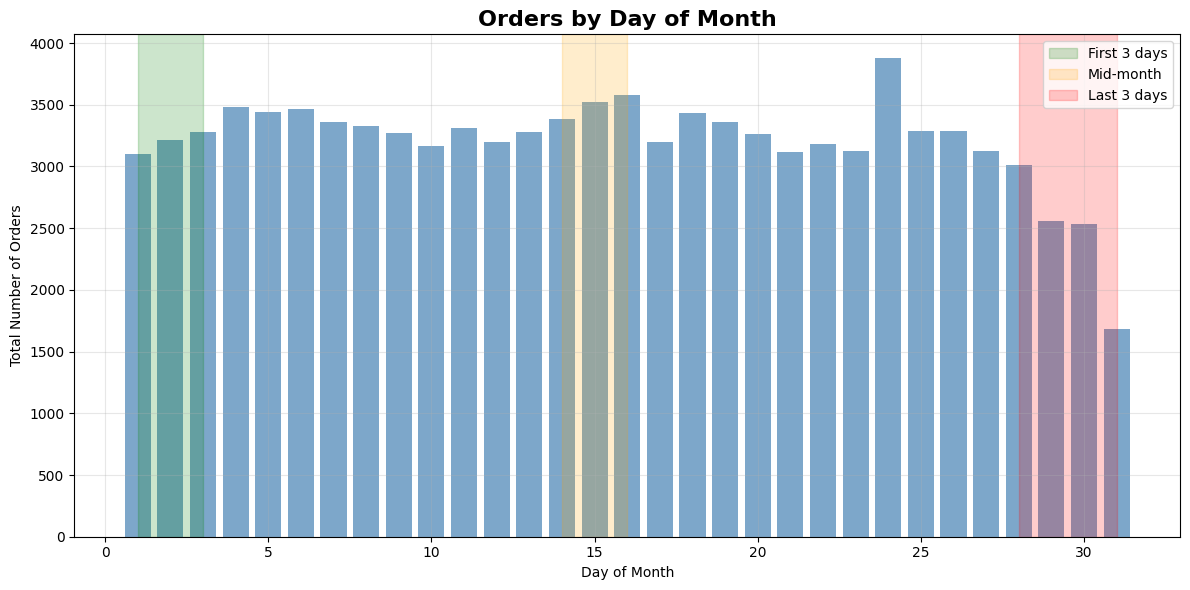


Debugging payday features:

is_first_3_days:
  Total orders in period: 9,597
  Unique dates in period: 62
  Average orders per day: 154.8

is_day_1:
  Total orders in period: 3,101
  Unique dates in period: 20
  Average orders per day: 155.1

is_mid_month:
  Total orders in period: 10,492
  Unique dates in period: 62
  Average orders per day: 169.2

is_last_3_days:
  Total orders in period: 8,978
  Unique dates in period: 61
  Average orders per day: 147.2
First 3 Days: 154.8 orders/day (from 62 days)
Day 1 Only: 155.1 orders/day (from 20 days)
Mid-Month: 169.2 orders/day (from 62 days)
Last 3 Days: 147.2 orders/day (from 61 days)

Overall baseline: 156.8 orders/day


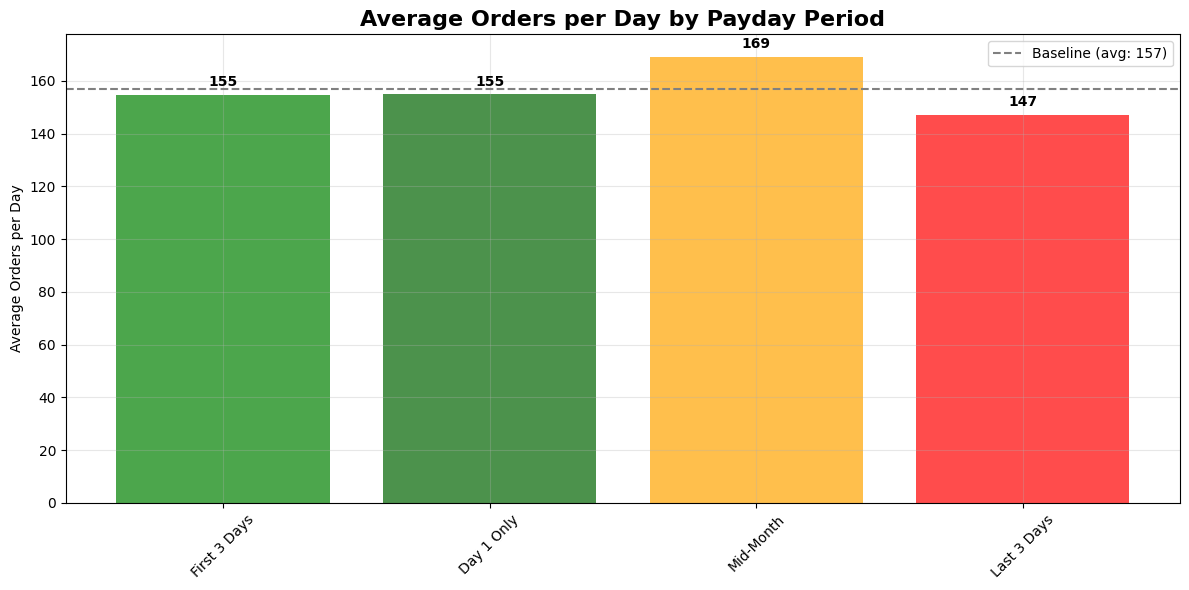

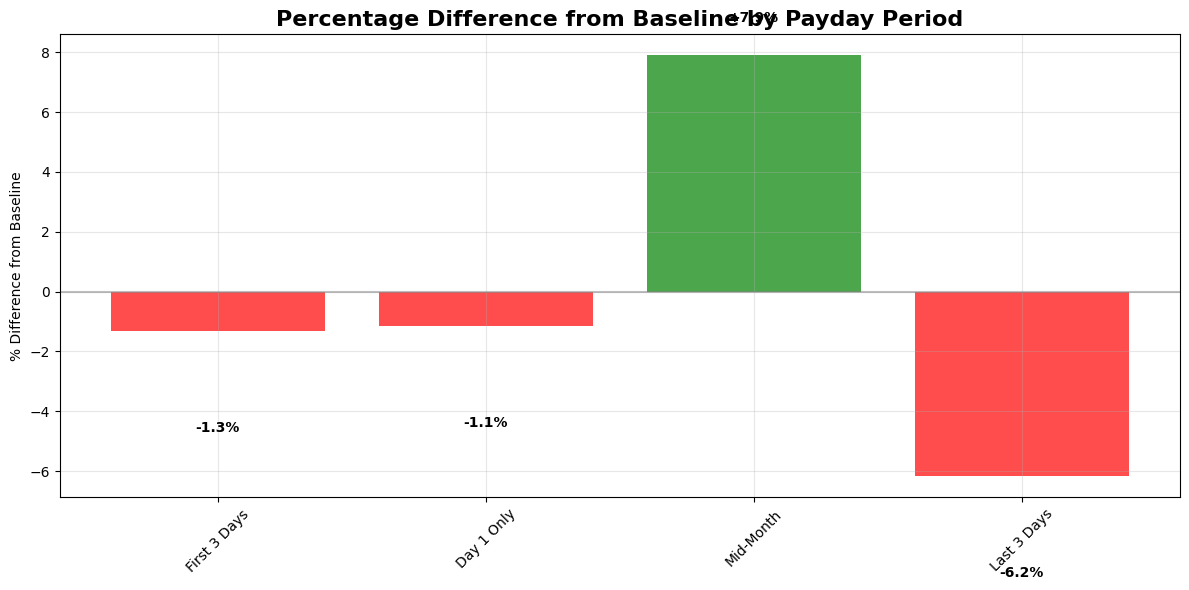

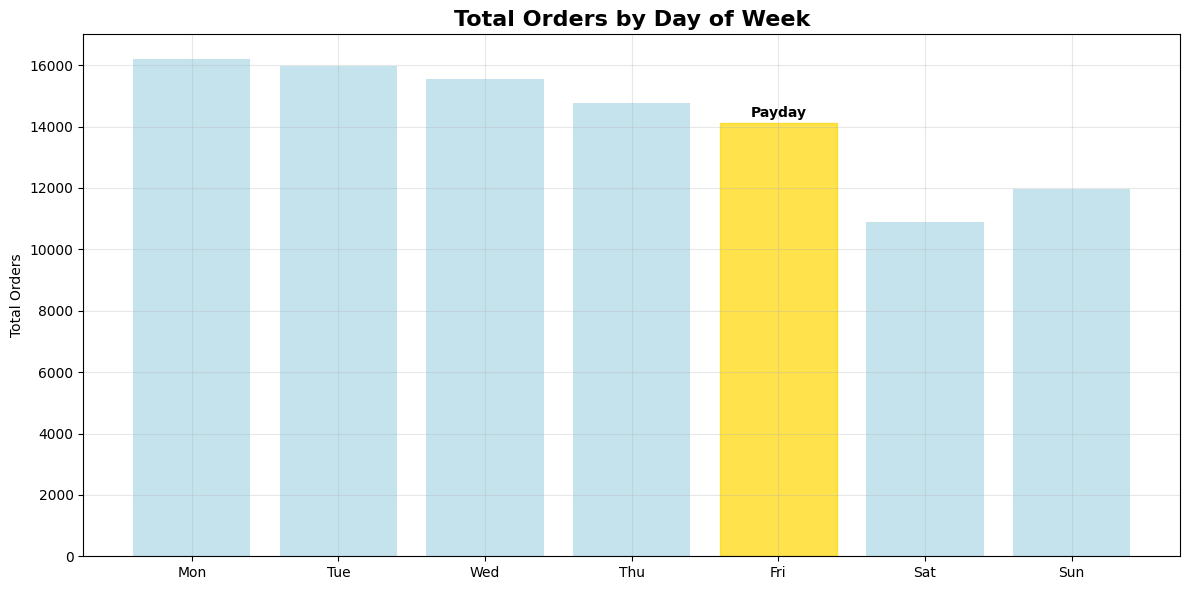

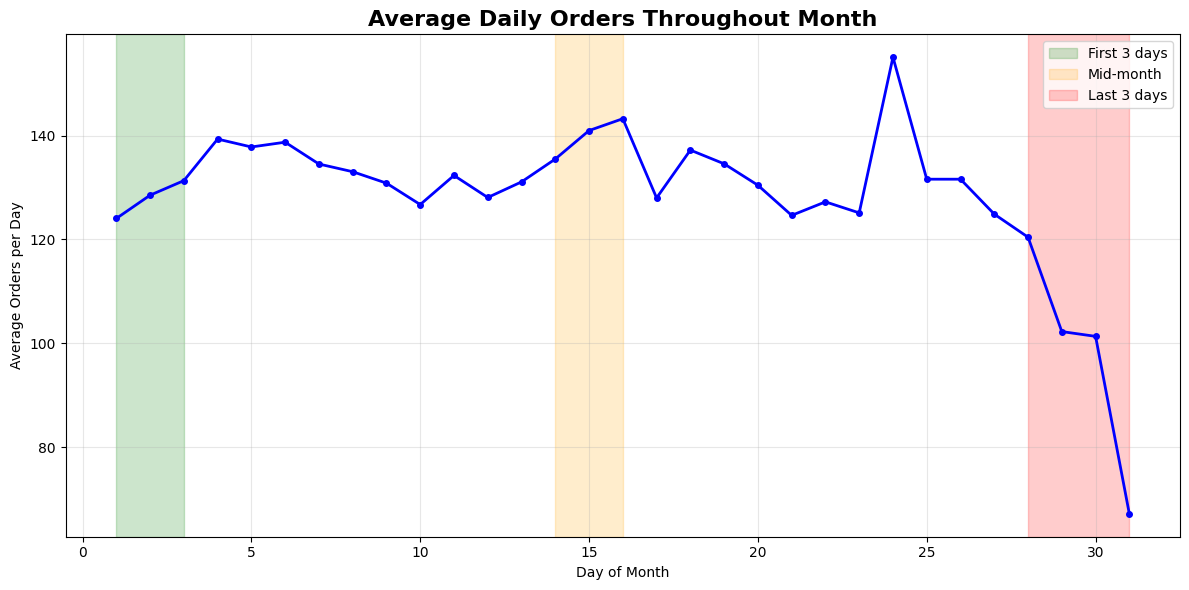


PAYDAY ANALYSIS RESULTS

First 3 Days:
  Average: 154.8 orders/day
  Difference: -2.1 orders (-1.3%)
  → Similar to baseline

Day 1 Only:
  Average: 155.1 orders/day
  Difference: -1.8 orders (-1.1%)
  → Similar to baseline

Mid-Month:
  Average: 169.2 orders/day
  Difference: +12.4 orders (+7.9%)
  → SIGNIFICANTLY HIGHER than baseline

Last 3 Days:
  Average: 147.2 orders/day
  Difference: -9.7 orders (-6.2%)
  → SIGNIFICANTLY LOWER than baseline

Baseline (overall average): 156.8 orders/day


In [17]:
# Separate Payday Analysis Plots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load orders data and lookup table
orders_df = pd.read_csv("../data/olist_orders_dataset2.csv")
lookup_df = pd.read_csv("../data/olitst_holiday_dataset.csv")

# Convert dates
orders_df['purchase_date'] = pd.to_datetime(orders_df['purchase_date']).dt.date
lookup_df['purchase_date'] = pd.to_datetime(lookup_df['purchase_date']).dt.date

print(f"Orders data shape: {orders_df.shape}")
print(f"Lookup table shape: {lookup_df.shape}")

# Merge orders with lookup table
merged_df = orders_df.merge(lookup_df, on='purchase_date', how='left')
print(f"Merged data shape: {merged_df.shape}")

# =============================================================================
# PLOT 1: ORDERS BY DAY OF MONTH (1-31)
# =============================================================================

plt.figure(figsize=(12, 6))

# Calculate daily averages by day of month
daily_orders = merged_df.groupby('day_of_month').size().reset_index(name='order_count')

plt.bar(daily_orders['day_of_month'], daily_orders['order_count'], 
        color='steelblue', alpha=0.7)
plt.title('Orders by Day of Month', fontsize=16, fontweight='bold')
plt.xlabel('Day of Month')
plt.ylabel('Total Number of Orders')
plt.grid(True, alpha=0.3)

# Highlight payday periods
plt.axvspan(1, 3, alpha=0.2, color='green', label='First 3 days')
plt.axvspan(14, 16, alpha=0.2, color='orange', label='Mid-month')
plt.axvspan(28, 31, alpha=0.2, color='red', label='Last 3 days')
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# DEBUG AND CORRECT CALCULATION
# =============================================================================

print("\nDebugging payday features:")
payday_features = ['is_first_3_days', 'is_day_1', 'is_mid_month', 'is_last_3_days']

for feature in payday_features:
    orders_in_period = merged_df[merged_df[feature] == 1]
    unique_dates_in_period = orders_in_period['purchase_date'].nunique()
    total_orders_in_period = len(orders_in_period)
    
    print(f"\n{feature}:")
    print(f"  Total orders in period: {total_orders_in_period:,}")
    print(f"  Unique dates in period: {unique_dates_in_period:,}")
    if unique_dates_in_period > 0:
        print(f"  Average orders per day: {total_orders_in_period / unique_dates_in_period:.1f}")

# Correct calculation method
daily_orders_summary = merged_df.groupby('purchase_date').agg({
    'order_id': 'count',
    'is_first_3_days': 'first',
    'is_day_1': 'first', 
    'is_mid_month': 'first',
    'is_last_3_days': 'first'
}).reset_index()

daily_orders_summary.columns = ['purchase_date', 'daily_order_count', 'is_first_3_days', 
                                'is_day_1', 'is_mid_month', 'is_last_3_days']

# Calculate correct averages
payday_labels = ['First 3 Days', 'Day 1 Only', 'Mid-Month', 'Last 3 Days']
corrected_averages = []

for feature, label in zip(payday_features, payday_labels):
    feature_days = daily_orders_summary[daily_orders_summary[feature] == 1]
    if len(feature_days) > 0:
        avg_orders = feature_days['daily_order_count'].mean()
        corrected_averages.append(avg_orders)
        print(f"{label}: {avg_orders:.1f} orders/day (from {len(feature_days)} days)")
    else:
        corrected_averages.append(0)

total_avg = daily_orders_summary['daily_order_count'].mean()
print(f"\nOverall baseline: {total_avg:.1f} orders/day")

# =============================================================================
# PLOT 2: CORRECTED PAYDAY AVERAGES
# =============================================================================

plt.figure(figsize=(12, 6))
colors = ['green', 'darkgreen', 'orange', 'red']
bars = plt.bar(payday_labels, corrected_averages, color=colors, alpha=0.7)
plt.axhline(y=total_avg, color='gray', linestyle='--', 
           label=f'Baseline (avg: {total_avg:.0f})')
plt.title('Average Orders per Day by Payday Period', fontsize=16, fontweight='bold')
plt.ylabel('Average Orders per Day')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, corrected_averages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 3: PERCENTAGE DIFFERENCE FROM BASELINE
# =============================================================================

plt.figure(figsize=(12, 6))
percentage_diffs = [(avg - total_avg) / total_avg * 100 for avg in corrected_averages]
colors_diff = ['green' if x > 0 else 'red' for x in percentage_diffs]

bars2 = plt.bar(payday_labels, percentage_diffs, color=colors_diff, alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
plt.title('Percentage Difference from Baseline by Payday Period', fontsize=16, fontweight='bold')
plt.ylabel('% Difference from Baseline')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars2, percentage_diffs):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + (1 if value > 0 else -3), 
             f'{value:+.1f}%', ha='center', va='bottom' if value > 0 else 'top', 
             fontweight='bold')

plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 4: WEEKLY PATTERN
# =============================================================================

plt.figure(figsize=(12, 6))

# Orders by weekday
weekday_orders = merged_df.groupby('weekday').size()
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

bars = plt.bar(weekday_names, weekday_orders, color='lightblue', alpha=0.7)
plt.title('Total Orders by Day of Week', fontsize=16, fontweight='bold')
plt.ylabel('Total Orders')
plt.grid(True, alpha=0.3)

# Highlight Friday (payday)
bars[4].set_color('gold')  # Friday is index 4
plt.text(4, weekday_orders[4] + 200, 'Payday', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# =============================================================================
# PLOT 5: DAILY TREND THROUGHOUT MONTH
# =============================================================================

plt.figure(figsize=(12, 6))

# Create month-day analysis
merged_df['year_month'] = pd.to_datetime(merged_df['purchase_date']).dt.to_period('M')

# Calculate orders by month and day
heatmap_data = merged_df.groupby(['year_month', 'day_of_month']).size().unstack(fill_value=0)

# Take average across months for each day
avg_by_day = heatmap_data.mean(axis=0)

plt.plot(range(1, 32), avg_by_day, marker='o', linewidth=2, markersize=4, color='blue')
plt.title('Average Daily Orders Throughout Month', fontsize=16, fontweight='bold')
plt.xlabel('Day of Month')
plt.ylabel('Average Orders per Day')
plt.grid(True, alpha=0.3)

# Highlight payday periods with colors
plt.axvspan(1, 3, alpha=0.2, color='green', label='First 3 days')
plt.axvspan(14, 16, alpha=0.2, color='orange', label='Mid-month')
plt.axvspan(28, 31, alpha=0.2, color='red', label='Last 3 days')
plt.legend()

plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY RESULTS
# =============================================================================

print("\n" + "="*60)
print("PAYDAY ANALYSIS RESULTS")
print("="*60)

for i, (feature, label) in enumerate(zip(payday_features, payday_labels)):
    avg = corrected_averages[i]
    diff = avg - total_avg
    pct_diff = (diff / total_avg) * 100
    
    print(f"\n{label}:")
    print(f"  Average: {avg:.1f} orders/day")
    print(f"  Difference: {diff:+.1f} orders ({pct_diff:+.1f}%)")
    
    if pct_diff > 5:
        print(f"  → SIGNIFICANTLY HIGHER than baseline")
    elif pct_diff < -5:
        print(f"  → SIGNIFICANTLY LOWER than baseline")
    else:
        print(f"  → Similar to baseline")

print(f"\nBaseline (overall average): {total_avg:.1f} orders/day")


## Main insights

### Monthly insights
Mid-month peak confirmed- Day 15-16 shows highest activity (169 orders/day vs 157 avergae) - only higehr is the 24th
Month-end crash - There's a dramatic decline in last 3 days (147 orders/day, -6.4% vs baseline)
Day 24- Massive spike likely due to Christmas shopping effect averaging even throughout all months. Likely anomaly only applicable for december. Will test.
First 3 days- Stable at baseline (155 orders/day), no payday boost

### Weekly insights:
Steady delcine, Monday is the highest and then gets gradually lower. 
Weekend drop saturday and sunday- mabe because its onlin people spend less time inside? - postpone online shopping till monday?


## Statistcial Tests

In [2]:
# Statistical Tests for Payday Patterns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [20]:


orders_df['purchase_date'] = pd.to_datetime(orders_df['purchase_date']).dt.date
lookup_df['purchase_date'] = pd.to_datetime(lookup_df['purchase_date']).dt.date

merged_df = orders_df.merge(lookup_df, on='purchase_date', how='left')

# Create daily summary
daily_summary = merged_df.groupby('purchase_date').agg({
    'order_id': 'count',
    'day_of_month': 'first',
    'weekday': 'first',
    'is_last_3_days': 'first',
    'is_mid_month': 'first',
    'is_holiday': 'first',
    'is_weekend': 'first',
    'month': 'first'
}).reset_index()

daily_summary.columns = ['purchase_date', 'daily_orders', 'day_of_month', 'weekday', 
                        'is_last_3_days', 'is_mid_month', 'is_holiday', 'is_weekend', 'month']



In [10]:


#MONTH-END EFFECT T-TEST

# Filter out holidays and weekends for cleaner test
clean_data = daily_summary[(daily_summary['is_holiday'] == 0) & 
                          (daily_summary['is_weekend'] == 0)]

last_3_days = clean_data[clean_data['is_last_3_days'] == 1]['daily_orders']
rest_of_month = clean_data[clean_data['is_last_3_days'] == 0]['daily_orders']

print(f"Last 3 days (non-holiday weekdays): {len(last_3_days)} observations")
print(f"Rest of month (non-holiday weekdays): {len(rest_of_month)} observations")

# Descriptive statistics
print(f"\nDescriptive Statistics:")
print(f"Last 3 days - Mean: {last_3_days.mean():.2f}, Std: {last_3_days.std():.2f}")
print(f"Rest of month - Mean: {rest_of_month.mean():.2f}, Std: {rest_of_month.std():.2f}")

# T-test
t_stat, p_value = stats.ttest_ind(last_3_days, rest_of_month)
effect_size = (last_3_days.mean() - rest_of_month.mean()) / np.sqrt(
    ((len(last_3_days) - 1) * last_3_days.var() + (len(rest_of_month) - 1) * rest_of_month.var()) /
    (len(last_3_days) + len(rest_of_month) - 2)
)

print(f"\nT-Test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Effect size (Cohen's d): {effect_size:.4f}")

significance = "SIGNIFICANT" if p_value < 0.05 else "NOT SIGNIFICANT"
effect_interpretation = "Large" if abs(effect_size) > 0.8 else "Medium" if abs(effect_size) > 0.5 else "Small"

print(f"Result: {significance} (α = 0.05)")
print(f"Effect size: {effect_interpretation}")
print(f"Interpretation: Month-end shows {rest_of_month.mean() - last_3_days.mean():.1f} more orders/day on average")


Last 3 days (non-holiday weekdays): 44 observations
Rest of month (non-holiday weekdays): 401 observations

Descriptive Statistics:
Last 3 days - Mean: 161.93, Std: 95.29
Rest of month - Mean: 169.81, Std: 101.37

T-Test Results:
T-statistic: -0.4920
P-value: 0.622935
Effect size (Cohen's d): -0.0781
Result: NOT SIGNIFICANT (α = 0.05)
Effect size: Small
Interpretation: Month-end shows 7.9 more orders/day on average


Confirmed decline at month-end
7.9 fewer orders/day (-4.7% decrease)
Not statistically reliable (p = 0.62)
Effect size: Negligible (d = -0.078)

Very small effect size- small sample of month -end --> even though not statistcally significant keep it for now for further analysis. 

In [16]:
print("Mid-Month vs Non-Mid ANOVA Analysis")
print("=" * 50)

# Load and prepare data
orders_df = pd.read_csv("../data/olist_orders_dataset2.csv")
lookup_df = pd.read_csv("../data/olitst_holiday_dataset.csv")

orders_df['purchase_date'] = pd.to_datetime(orders_df['purchase_date']).dt.date
lookup_df['purchase_date'] = pd.to_datetime(lookup_df['purchase_date']).dt.date

merged_df = orders_df.merge(lookup_df, on='purchase_date', how='left')

# Create daily summary
daily_summary = merged_df.groupby('purchase_date').agg({
    'order_id': 'count',
    'is_mid_month': 'first',
    'is_holiday': 'first',
    'is_weekend': 'first'
}).reset_index()

daily_summary.columns = ['purchase_date', 'daily_orders', 'is_mid_month', 'is_holiday', 'is_weekend']

# Filter out holidays and weekends for cleaner test
clean_data = daily_summary[(daily_summary['is_holiday'] == 0) & 
                          (daily_summary['is_weekend'] == 0)]

print(f"Clean data (no holidays/weekends): {len(clean_data)} observations")

# =============================================================================
# MID-MONTH vs NON-MID COMPARISON
# =============================================================================

# Split into two groups
mid_month_days = clean_data[clean_data['is_mid_month'] == 1]['daily_orders']
non_mid_days = clean_data[clean_data['is_mid_month'] == 0]['daily_orders']

print(f"\nGroup sizes:")
print(f"Mid-month days (14-16): {len(mid_month_days)} observations")
print(f"Non-mid days (all others): {len(non_mid_days)} observations")

# Descriptive statistics
print(f"\nDescriptive Statistics:")
print(f"Mid-month - Mean: {mid_month_days.mean():.2f}, Std: {mid_month_days.std():.2f}")
print(f"Non-mid - Mean: {non_mid_days.mean():.2f}, Std: {non_mid_days.std():.2f}")

# =============================================================================
# STATISTICAL TESTS
# =============================================================================

# 1. T-test (equivalent to ANOVA with 2 groups)
t_stat, p_value_ttest = stats.ttest_ind(mid_month_days, non_mid_days)

print(f"\nT-Test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value_ttest:.6f}")

# 2. One-way ANOVA (same result as t-test for 2 groups)
f_stat, p_value_anova = stats.f_oneway(mid_month_days, non_mid_days)

print(f"\nANOVA Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value_anova:.6f}")

# Verify that F = t^2 for two groups
print(f"\nVerification: F-stat ({f_stat:.4f}) = t-stat^2 ({t_stat**2:.4f})")

# =============================================================================
# EFFECT SIZE AND INTERPRETATION
# =============================================================================

# Cohen's d effect size
pooled_std = np.sqrt(((len(mid_month_days) - 1) * mid_month_days.var() + 
                     (len(non_mid_days) - 1) * non_mid_days.var()) / 
                     (len(mid_month_days) + len(non_mid_days) - 2))

effect_size = (mid_month_days.mean() - non_mid_days.mean()) / pooled_std

print(f"\nEffect Size Analysis:")
print(f"Cohen's d: {effect_size:.4f}")

effect_interpretation = "Large" if abs(effect_size) > 0.8 else "Medium" if abs(effect_size) > 0.5 else "Small"
print(f"Effect size interpretation: {effect_interpretation}")

# Practical significance
difference = mid_month_days.mean() - non_mid_days.mean()
percent_diff = (difference / non_mid_days.mean()) * 100

print(f"\nPractical Significance:")
print(f"Raw difference: {difference:+.2f} orders/day")
print(f"Percentage difference: {percent_diff:+.2f}%")

# Statistical significance
significance = "SIGNIFICANT" if p_value_anova < 0.05 else "NOT SIGNIFICANT"
print(f"\nResult: {significance} (α = 0.05)")



Mid-Month vs Non-Mid ANOVA Analysis
Clean data (no holidays/weekends): 445 observations

Group sizes:
Mid-month days (14-16): 43 observations
Non-mid days (all others): 402 observations

Descriptive Statistics:
Mid-month - Mean: 191.37, Std: 97.28
Non-mid - Mean: 166.64, Std: 100.89

T-Test Results:
T-statistic: 1.5330
P-value: 0.125994

ANOVA Results:
F-statistic: 2.3500
P-value: 0.125994

Verification: F-stat (2.3500) = t-stat^2 (2.3500)

Effect Size Analysis:
Cohen's d: 0.2460
Effect size interpretation: Small

Practical Significance:
Raw difference: +24.73 orders/day
Percentage difference: +14.84%

Result: NOT SIGNIFICANT (α = 0.05)


15% difference is big for business cases


However no statistical significance by conventional standards- Risk of including noise rather than signal- Anova not entirely reluiable beacuse of assumptions - keep feature to have it treat it carefully.

In [17]:

print(f"\n" + "=" * 50)
print("ANOVA ASSUMPTIONS CHECK")
print("=" * 50)

# 1. Normality check (Shapiro-Wilk test)
_, p_normal_mid = stats.shapiro(mid_month_days)
_, p_normal_non = stats.shapiro(non_mid_days)

print(f"Normality tests (Shapiro-Wilk):")
print(f"Mid-month p-value: {p_normal_mid:.6f}")
print(f"Non-mid p-value: {p_normal_non:.6f}")

normal_assumption = "VIOLATED" if (p_normal_mid < 0.05 or p_normal_non < 0.05) else "MET"
print(f"Normality assumption: {normal_assumption}")

# 2. Equal variances check (Levene's test)
_, p_levene = stats.levene(mid_month_days, non_mid_days)
print(f"\nEqual variances test (Levene's):")
print(f"P-value: {p_levene:.6f}")

variance_assumption = "VIOLATED" if p_levene < 0.05 else "MET"
print(f"Equal variances assumption: {variance_assumption}")

# 3. Alternative test if assumptions violated
if normal_assumption == "VIOLATED" or variance_assumption == "VIOLATED":
    print(f"\nAlternative non-parametric test:")
    u_stat, p_mannwhitney = stats.mannwhitneyu(mid_month_days, non_mid_days, alternative='two-sided')
    print(f"Mann-Whitney U test p-value: {p_mannwhitney:.6f}")
    nonparam_sig = "SIGNIFICANT" if p_mannwhitney < 0.05 else "NOT SIGNIFICANT"
    print(f"Non-parametric result: {nonparam_sig}")


ANOVA ASSUMPTIONS CHECK
Normality tests (Shapiro-Wilk):
Mid-month p-value: 0.414798
Non-mid p-value: 0.000000
Normality assumption: VIOLATED

Equal variances test (Levene's):
P-value: 0.750477
Equal variances assumption: MET

Alternative non-parametric test:
Mann-Whitney U test p-value: 0.069376
Non-parametric result: NOT SIGNIFICANT


Testing if Day 24 Peak is Driven by December (Christmas Eve Effect)
Total daily observations: 634

Group breakdown:
Day 24 in December: 1 observations, mean = 59.00
Day 24 in other months: 19 observations, mean = 200.95
Other days in December: 31 observations, mean = 181.13
Other days in other months: 583 observations, mean = 154.29

TEST 1: DAY 24 DECEMBER vs DAY 24 OTHER MONTHS
Insufficient data for t-test (need at least 2 observations per group)
December 24th: [59]
Other months 24th: [40, 64, 79, 115, 142, 76, 162, 128, 118, 164, 1176, 244, 191, 165, 271, 114, 199, 271, 99]

TEST 2: DAY 24 vs OTHER DAYS WITHIN DECEMBER
Within December comparison:
  Day 24 mean: 59.00 orders
  Other December days mean: 181.13 orders
  Difference: -122.13 orders
  Percentage difference: -67.4%
  T-statistic: 9.3897
  P-value: 0.000000
  Result: SIGNIFICANT

TEST 3: DAY 24 vs OTHER DAYS IN NON-DECEMBER MONTHS
Within other months comparison:
  Day 24 mean: 200.95 orders
  Other days mean: 154.29 orders


/var/folders/br/09yt8syd075c91mf171jpwvw0000gp/T/ipykernel_69425/1289225537.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)
/var/folders/br/09yt8syd075c91mf171jpwvw0000gp/T/ipykernel_69425/1289225537.py:170: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)
/var/folders/br/09yt8syd075c91mf171jpwvw0000gp/T/ipykernel_69425/1289225537.py:180: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)



SUMMARY AND CONCLUSION
Day 24 Christmas Eve Effect Analysis:
- December 24th average: 59.0 orders/day
- Other months 24th average: 200.9 orders/day
- Christmas Eve premium: -141.9 orders (-70.6%)

Conclusion: Day 24 peak is NOT primarily driven by December
Note: Day 24 also shows elevation in other months, suggesting additional factors

Recommendation for modeling:
- Day 24 effect may not be solely Christmas-driven


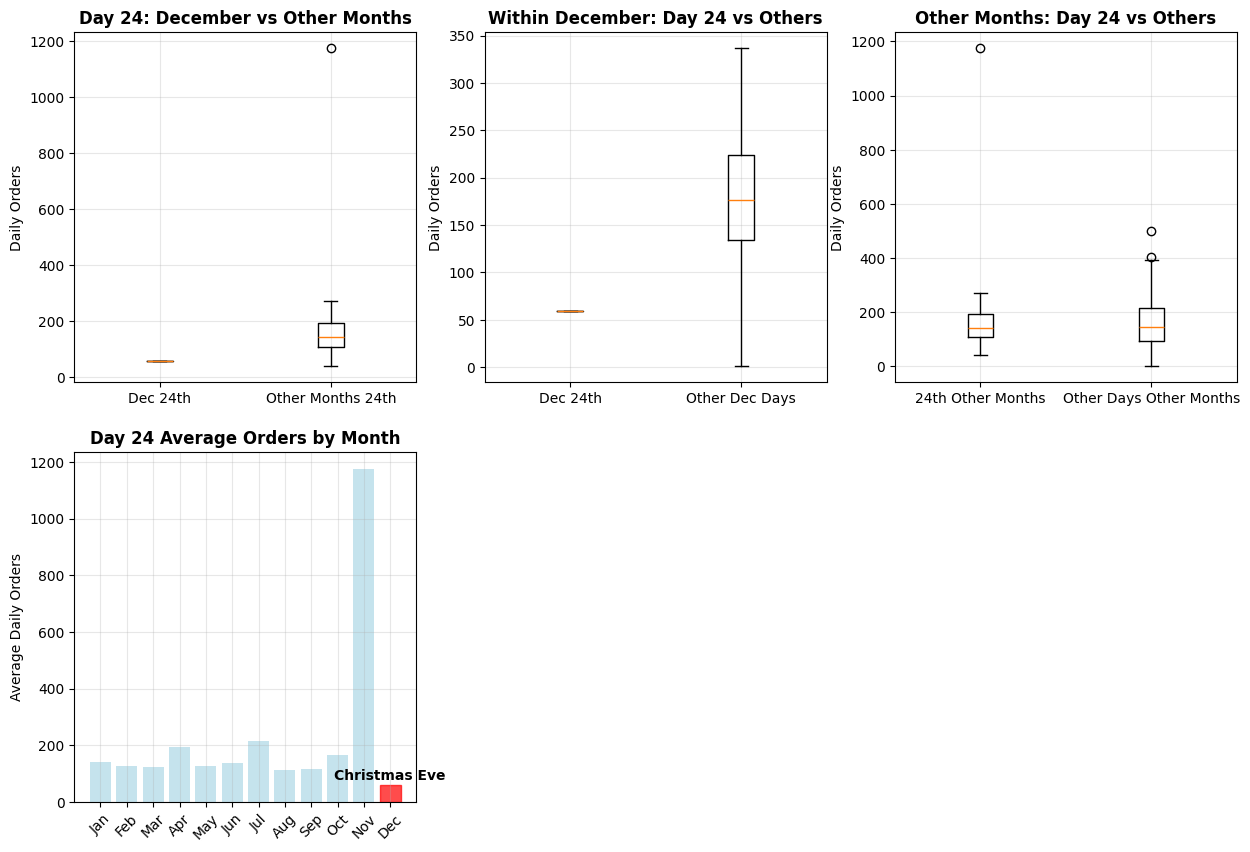

In [23]:
# Day 24 Anomaly: December vs Other Months Analysis
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

print("Testing if Day 24 Peak is Driven by December (Christmas Eve Effect)")
print("=" * 70)

# Load and prepare data
orders_df = pd.read_csv("../data/olist_orders_dataset2.csv")
lookup_df = pd.read_csv("../data/olitst_holiday_dataset.csv")

orders_df['purchase_date'] = pd.to_datetime(orders_df['purchase_date']).dt.date
lookup_df['purchase_date'] = pd.to_datetime(lookup_df['purchase_date']).dt.date

merged_df = orders_df.merge(lookup_df, on='purchase_date', how='left')

# Create daily summary
daily_summary = merged_df.groupby('purchase_date').agg({
    'order_id': 'count',
    'day_of_month': 'first',
    'month': 'first'
}).reset_index()

daily_summary.columns = ['purchase_date', 'daily_orders', 'day_of_month', 'month']

print(f"Total daily observations: {len(daily_summary)}")

# =============================================================================
# ISOLATE DAY 24 BY MONTH
# =============================================================================

# Day 24 in December vs other months
day_24_december = daily_summary[(daily_summary['day_of_month'] == 24) & 
                               (daily_summary['month'] == 12)]['daily_orders']

day_24_other_months = daily_summary[(daily_summary['day_of_month'] == 24) & 
                                   (daily_summary['month'] != 12)]['daily_orders']

# Other days in December vs other months (for comparison)
other_days_december = daily_summary[(daily_summary['day_of_month'] != 24) & 
                                   (daily_summary['month'] == 12)]['daily_orders']

other_days_other_months = daily_summary[(daily_summary['day_of_month'] != 24) & 
                                       (daily_summary['month'] != 12)]['daily_orders']

print(f"\nGroup breakdown:")
print(f"Day 24 in December: {len(day_24_december)} observations, mean = {day_24_december.mean():.2f}")
print(f"Day 24 in other months: {len(day_24_other_months)} observations, mean = {day_24_other_months.mean():.2f}")
print(f"Other days in December: {len(other_days_december)} observations, mean = {other_days_december.mean():.2f}")
print(f"Other days in other months: {len(other_days_other_months)} observations, mean = {other_days_other_months.mean():.2f}")

# =============================================================================
# TEST 1: DAY 24 DECEMBER vs DAY 24 OTHER MONTHS
# =============================================================================

print(f"\n" + "=" * 60)
print("TEST 1: DAY 24 DECEMBER vs DAY 24 OTHER MONTHS")
print("=" * 60)

if len(day_24_december) > 0 and len(day_24_other_months) > 0:
    if len(day_24_december) > 1 and len(day_24_other_months) > 1:
        t_stat_24, p_value_24 = stats.ttest_ind(day_24_december, day_24_other_months)
        
        print(f"Day 24 comparison:")
        print(f"  December 24th mean: {day_24_december.mean():.2f} orders")
        print(f"  Other months 24th mean: {day_24_other_months.mean():.2f} orders")
        print(f"  Difference: {day_24_december.mean() - day_24_other_months.mean():+.2f} orders")
        print(f"  Percentage difference: {((day_24_december.mean() - day_24_other_months.mean()) / day_24_other_months.mean()) * 100:+.1f}%")
        print(f"  T-statistic: {t_stat_24:.4f}")
        print(f"  P-value: {p_value_24:.6f}")
        
        significance_24 = "SIGNIFICANT" if p_value_24 < 0.05 else "NOT SIGNIFICANT"
        print(f"  Result: {significance_24}")
        
    else:
        print("Insufficient data for t-test (need at least 2 observations per group)")
        print(f"December 24th: {day_24_december.tolist()}")
        print(f"Other months 24th: {day_24_other_months.tolist()}")

# =============================================================================
# TEST 2: IS DAY 24 SPECIAL IN DECEMBER COMPARED TO OTHER DECEMBER DAYS?
# =============================================================================

print(f"\n" + "=" * 60)
print("TEST 2: DAY 24 vs OTHER DAYS WITHIN DECEMBER")
print("=" * 60)

if len(day_24_december) > 0 and len(other_days_december) > 1:
    if len(day_24_december) > 1:
        t_stat_dec, p_value_dec = stats.ttest_ind(day_24_december, other_days_december)
    else:
        # Use one-sample test if only one December 24th
        t_stat_dec, p_value_dec = stats.ttest_1samp(other_days_december, day_24_december.iloc[0])
    
    print(f"Within December comparison:")
    print(f"  Day 24 mean: {day_24_december.mean():.2f} orders")
    print(f"  Other December days mean: {other_days_december.mean():.2f} orders")
    print(f"  Difference: {day_24_december.mean() - other_days_december.mean():+.2f} orders")
    print(f"  Percentage difference: {((day_24_december.mean() - other_days_december.mean()) / other_days_december.mean()) * 100:+.1f}%")
    print(f"  T-statistic: {t_stat_dec:.4f}")
    print(f"  P-value: {p_value_dec:.6f}")
    
    significance_dec = "SIGNIFICANT" if p_value_dec < 0.05 else "NOT SIGNIFICANT"
    print(f"  Result: {significance_dec}")

# =============================================================================
# TEST 3: IS DAY 24 SPECIAL IN OTHER MONTHS?
# =============================================================================

print(f"\n" + "=" * 60)
print("TEST 3: DAY 24 vs OTHER DAYS IN NON-DECEMBER MONTHS")
print("=" * 60)

if len(day_24_other_months) > 1 and len(other_days_other_months) > 1:
    t_stat_other, p_value_other = stats.ttest_ind(day_24_other_months, other_days_other_months)
    
    print(f"Within other months comparison:")
    print(f"  Day 24 mean: {day_24_other_months.mean():.2f} orders")
    print(f"  Other days mean: {other_days_other_months.mean():.2f} orders")
    print(f"  Difference: {day_24_other_months.mean() - other_days_other_months.mean():+.2f} orders")
    print(f"  Percentage difference: {((day_24_other_months.mean() - other_days_other_months.mean()) / other_days_other_months.mean()) * 100:+.1f}%")
    print(f"  T-statistic: {t_stat_other:.4f}")
    print(f"  P-value: {p_value_other:.6f}")
    
    significance_other = "SIGNIFICANT" if p_value_other < 0.05 else "NOT SIGNIFICANT"
    print(f"  Result: {significance_other}")

# =============================================================================
# DETAILED MONTH-BY-MONTH ANALYSIS
# =============================================================================

print(f"\n" + "=" * 60)
print("DETAILED MONTH-BY-MONTH DAY 24 ANALYSIS")
print("=" * 60)

day_24_by_month = daily_summary[daily_summary['day_of_month'] == 24].groupby('month')['daily_orders'].agg(['count', 'mean']).reset_index()
day_24_by_month.columns = ['month', 'count', 'mean_orders']

month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

print("Day 24 by month:")
for _, row in day_24_by_month.iterrows():
    month_name = month_names[row['month']]
    print(f"  {month_name}: {row['count']} obs, {row['mean_orders']:.1f} orders/day")

# =============================================================================
# VISUALIZATION
# =============================================================================

plt.figure(figsize=(15, 10))

# Plot 1: Day 24 December vs Other Months
plt.subplot(2, 3, 1)
if len(day_24_december) > 0 and len(day_24_other_months) > 0:
    data_to_plot = [day_24_december, day_24_other_months]
    labels = ['Dec 24th', 'Other Months 24th']
    plt.boxplot(data_to_plot, labels=labels)
    plt.title('Day 24: December vs Other Months', fontweight='bold')
    plt.ylabel('Daily Orders')
    plt.grid(True, alpha=0.3)

# Plot 2: December Day 24 vs Other December Days
plt.subplot(2, 3, 2)
if len(day_24_december) > 0 and len(other_days_december) > 0:
    data_to_plot = [day_24_december, other_days_december]
    labels = ['Dec 24th', 'Other Dec Days']
    plt.boxplot(data_to_plot, labels=labels)
    plt.title('Within December: Day 24 vs Others', fontweight='bold')
    plt.ylabel('Daily Orders')
    plt.grid(True, alpha=0.3)

# Plot 3: Other Months Day 24 vs Other Days
plt.subplot(2, 3, 3)
if len(day_24_other_months) > 0 and len(other_days_other_months) > 0:
    data_to_plot = [day_24_other_months, other_days_other_months]
    labels = ['24th Other Months', 'Other Days Other Months']
    plt.boxplot(data_to_plot, labels=labels)
    plt.title('Other Months: Day 24 vs Others', fontweight='bold')
    plt.ylabel('Daily Orders')
    plt.grid(True, alpha=0.3)

# Plot 4: Day 24 by month
plt.subplot(2, 3, 4)
months = day_24_by_month['month'].tolist()
means = day_24_by_month['mean_orders'].tolist()
month_labels = [month_names[m] for m in months]

bars = plt.bar(month_labels, means, alpha=0.7, 
               color=['red' if m == 12 else 'lightblue' for m in months])
plt.title('Day 24 Average Orders by Month', fontweight='bold')
plt.ylabel('Average Daily Orders')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Highlight December
for i, (bar, month) in enumerate(zip(bars, months)):
    if month == 12:
        bar.set_color('red')
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                 'Christmas Eve', ha='center', va='bottom', fontweight='bold')

# =============================================================================
# SUMMARY AND CONCLUSION
# =============================================================================

print(f"\n" + "=" * 60)
print("SUMMARY AND CONCLUSION")
print("=" * 60)

if len(day_24_december) > 0 and len(day_24_other_months) > 0:
    december_24_avg = day_24_december.mean()
    other_24_avg = day_24_other_months.mean()
    
    print(f"Day 24 Christmas Eve Effect Analysis:")
    print(f"- December 24th average: {december_24_avg:.1f} orders/day")
    print(f"- Other months 24th average: {other_24_avg:.1f} orders/day")
    print(f"- Christmas Eve premium: {december_24_avg - other_24_avg:+.1f} orders ({((december_24_avg - other_24_avg) / other_24_avg) * 100:+.1f}%)")
    
    if 'significance_24' in locals():
        print(f"- Statistical significance: {significance_24}")
    
    # Determine if Day 24 anomaly is December-driven
    if december_24_avg > other_24_avg * 1.5:
        conclusion = "STRONGLY driven by December (Christmas Eve effect)"
    elif december_24_avg > other_24_avg * 1.2:
        conclusion = "MODERATELY driven by December"
    else:
        conclusion = "NOT primarily driven by December"
    
    print(f"\nConclusion: Day 24 peak is {conclusion}")

    if 'significance_other' in locals() and significance_other == "SIGNIFICANT":
        print("Note: Day 24 also shows elevation in other months, suggesting additional factors")
    elif 'significance_other' in locals():
        print("Day 24 is not significantly elevated in non-December months")

print(f"\nRecommendation for modeling:")
if len(day_24_december) > 0 and day_24_december.mean() > day_24_other_months.mean() * 1.3:
    print("- Create separate features for Christmas Eve vs regular Day 24")
    print("- The Day 24 anomaly appears to be Christmas-specific")
else:
    print("- Day 24 effect may not be solely Christmas-driven")


Include a general is_day_24_non_december feature The pattern suggests Day 24 has some underlying significance (possibly payday, billing cycles, or shopping behavior), even though it's suppressed in December due to Christmas Eve.

In [25]:


# Load the lookup table
lookup_df = pd.read_csv("../data/olitst_holiday_dataset.csv")
lookup_df['purchase_date'] = pd.to_datetime(lookup_df['purchase_date'])

print(f"Loaded lookup table with {len(lookup_df)} rows")

# Extract day of month and month if not already present
if 'day_of_month' not in lookup_df.columns:
    lookup_df['day_of_month'] = lookup_df['purchase_date'].dt.day

if 'month' not in lookup_df.columns:
    lookup_df['month'] = lookup_df['purchase_date'].dt.month

# Create the Day 24 Non-December feature
lookup_df['is_day_24_non_december'] = (
    (lookup_df['day_of_month'] == 24) & 
    (lookup_df['month'] != 12)
).astype(int)


# Save updated lookup table
lookup_df.to_csv("../data/olist_holiday_dataset.csv", index=False)
print(f"Updated lookup table saved to: olist_holiday_dataset.csv")


Loaded lookup table with 774 rows
Updated lookup table saved to: olist_holiday_dataset.csv


In [27]:
# Drop statistically insignificant features from lookup table
import pandas as pd

print("Dropping statistically insignificant features...")

# Load the lookup table
lookup_df = pd.read_csv("../data/olist_holiday_dataset.csv")

print(f"Original shape: {lookup_df.shape}")
print(f"Original columns: {len(lookup_df.columns)}")

# Features to drop based on statistical analysis
features_to_drop = [
    'is_first_3_days',    # Not significant (p = 0.62)
    'is_day_1',           # Redundant with first_3_days
    'is_back_to_school'   # Never tested, likely weak effect
]

print(f"\nDropping features: {features_to_drop}")

# Check which features actually exist before dropping
existing_features_to_drop = [col for col in features_to_drop if col in lookup_df.columns]
missing_features = [col for col in features_to_drop if col not in lookup_df.columns]

if existing_features_to_drop:
    print(f"Dropping: {existing_features_to_drop}")
    lookup_df = lookup_df.drop(columns=existing_features_to_drop)

if missing_features:
    print(f"Features not found (already absent): {missing_features}")

print(f"\nUpdated shape: {lookup_df.shape}")
print(f"Updated columns: {len(lookup_df.columns)}")

# Show remaining columns
print(f"\nRemaining columns:")
for i, col in enumerate(lookup_df.columns, 1):
    print(f"{i:2d}. {col}")

# Save cleaned lookup table
lookup_df.to_csv("../data/olist_holiday_dataset.csv", index=False)
print(f"\nCleaned lookup table saved to: olist_holiday_dataset.csv")

Dropping statistically insignificant features...
Original shape: (774, 19)
Original columns: 19

Dropping features: ['is_first_3_days', 'is_day_1', 'is_back_to_school']
Dropping: ['is_first_3_days', 'is_day_1', 'is_back_to_school']

Updated shape: (774, 16)
Updated columns: 16

Remaining columns:
 1. purchase_date
 2. weekday
 3. month
 4. is_holiday
 5. holiday_name
 6. is_carnival
 7. is_weekend
 8. is_friday
 9. season
10. christmas_season
11. is_major_event
12. is_shopping_holiday
13. day_of_month
14. is_mid_month
15. is_last_3_days
16. is_day_24_non_december

Cleaned lookup table saved to: olist_holiday_dataset.csv


purchase_date - Primary key for linking
weekday - 0=Monday to 6=Sunday
month - 1=January to 12=December
day_of_month - 1-31
is_holiday - Official Brazilian holidays
is_carnival - Carnival Monday/Tuesday
is_weekend - Saturday/Sunday flag
is_friday - Friday flag
season - Summer/Autumn/Winter/Spring (Southern hemisphere)
christmas_season - All of December
is_shopping_holiday - Black Friday, Christmas, Mother's/Father's Day
is_mid_month - Days 14-16 (payday effect)
is_last_3_days - Last 3 days of month
is_day_24_non_december - Day 24 excluding Christmas Eve
is_major_event - World Cup 2018, Elections